In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from math import floor
from random import sample


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

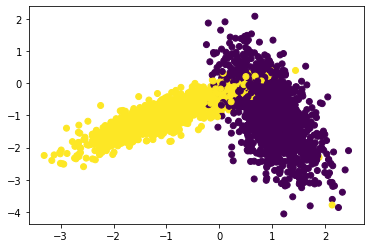

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [4]:
def get_folds(l,f):#This function returns the folded list of indices
  folds=[]
  one_fold=floor(l/f)
  for fold in range(f-1):
    folds.append(list(range((one_fold*fold),(one_fold*(fold+1)))))
  
  folds.append(list(range(folds[-1][-1]+1,l)))

  return folds #ex: for 10 vals of 2 folds: [[0,1,2,3,4],[5,6,7,8,9]]

def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
  #Finding random parameters from given range
  params=sorted(list(map(floor,sample(range(param_range[0],param_range[1]+1),10))))
  
  #Getting folded list
  fold_idx=get_folds(len(x_train),folds)

  train_scores=[]
  test_scores=[]

  for parameter in tqdm(params):
    train_scores_folds=[]
    test_scores_folds=[]

    for fold in range(folds):
      
      #Getting indices for data
      test_data_indices=fold_idx[fold]
      train_data_indices=list(set(range(1,len(x_train)))-set(test_data_indices))

      #Obtaining data from indices
      train_data=x_train[train_data_indices]
      test_data=x_train[test_data_indices]
      train_target=y_train[train_data_indices]
      test_target=y_train[test_data_indices]

      #Setting the parameter for classifier
      classifier.n_neighbors = parameter
      #Fitting model for specific parameter
      classifier.fit(train_data,train_target)

      #Finding and saving accuracy for test data
      Y_predicted = classifier.predict(test_data)
      test_scores_folds.append(accuracy_score(test_target, Y_predicted))

      #Finding and saving accuracy for train data
      Y_predicted = classifier.predict(train_data)
      train_scores_folds.append(accuracy_score(train_target, Y_predicted))

    #Saving mean of accuracies for specific parameter
    train_scores.append(np.mean(np.array(train_scores_folds)))
    test_scores.append(np.mean(np.array(test_scores_folds)))
  return train_scores,test_scores,params

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


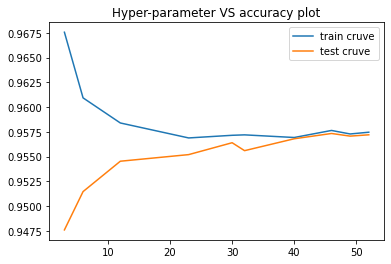

Best Hyperparameter found: 40


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()

params = (1,60)
folds = 4

trainscores,testscores,parameters = RandomSearchCV(X_train, y_train, neigh, params, folds)
 
plt.plot(parameters,trainscores, label='train cruve')
plt.plot(parameters,testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

diff=[abs(trainscores[i]-testscores[i]) for i in range(10)]
print("Best Hyperparameter found:",parameters[diff.index([min(diff)])])


In [9]:
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

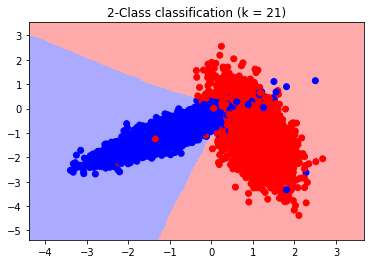

In [10]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 21)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)